## EDA for the popular battle royale game PUBG

<img src="https://pmcvariety.files.wordpress.com/2018/04/pubg.jpg?w=1000&h=563&crop=1" alt="PUBG" style="width: 750px;"/>

This kernel features:
- [The Killers](#The-Killers)
- [The Runners](#The-Runners)
- [The Drivers](#The-Drivers)
- [The Swimmers](#The-Swimmers)
- [The Healers](#The-Healers)
- [Solos, Duos and Squads](#Solos,-Duos-and-Squads)
- [Correlation](#Pearson-correlation-between-variables)
- [Feature Engineering](#Feature-Engineering)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('../data/train_V2.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


- **groupId** - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- **matchId** - Integer ID to identify match. There are no matches that are in both the training and testing set.
- **assists** - Number of enemy players this player damaged that were killed by teammates.
- **boosts** - Number of boost items used.
- **damageDealt** - Total damage dealt. Note: Self inflicted damage is subtracted.
- **DBNOs** - Number of enemy players knocked.
- **headshotKills** - Number of enemy players killed with headshots.
- **heals** - Number of healing items used.
- **killPlace** - Ranking in match of number of enemy players killed.
- **killPoints** - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.)
- **kills** - Number of enemy players killed.
- **killStreaks** - Max number of enemy players killed in a short amount of time.
- **longestKill** - Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.
- **maxPlace** - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- **numGroups** - Number of groups we have data for in the match.
- **revives** - Number of times this player revived teammates.
- **rideDistance** - Total distance traveled in vehicles measured in meters.
- **roadKills** - Number of kills while in a vehicle.
- **swimDistance** - Total distance traveled by swimming measured in meters.
- **teamKills** - Number of times this player killed a teammate.
- **vehicleDestroys** - Number of vehicles destroyed.
- **walkDistance** - Total distance traveled on foot measured in meters.
- **weaponsAcquired** - Number of weapons picked up.
- **winPoints** - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)
- **winPlacePerc** - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [4]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


Ok, now that we have a glimpse of the data, let's explore them.

## The Killers

<img src="https://i.ytimg.com/vi/rnAeX795Jn0/maxresdefault.jpg" alt="The Killers" style="width: 700px;"/>

In [5]:
print("The average person kills {:.4f} players, 99% of people have {} kills or less, while the most kills ever recorded is {}.".format(train['kills'].mean(),train['kills'].quantile(0.99), train['kills'].max()))

The average person kills 0.9248 players, 99% of people have 7.0 kills or less, while the most kills ever recorded is 72.


Let's plot the kill counts.

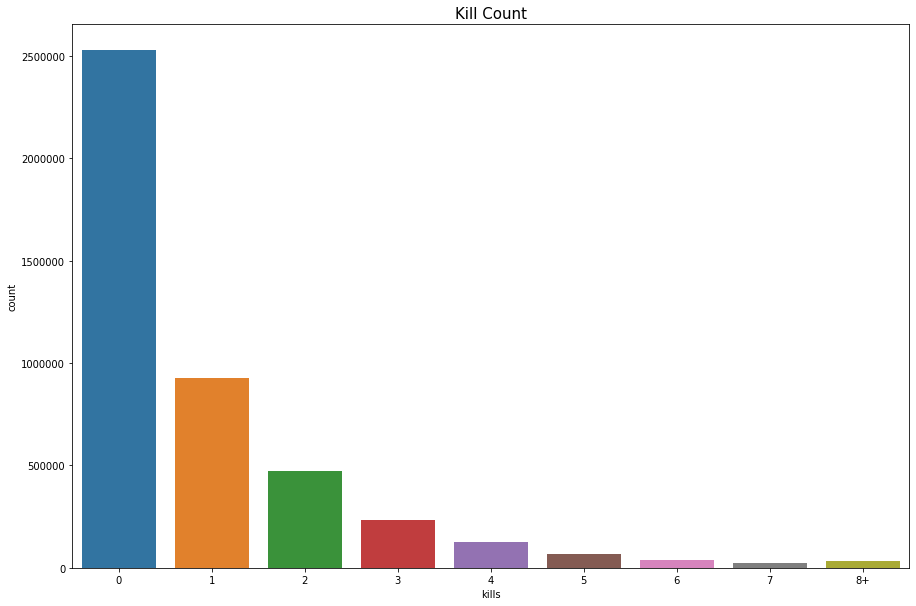

In [6]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()

Most people can't make a single kill. At least do they do damage?

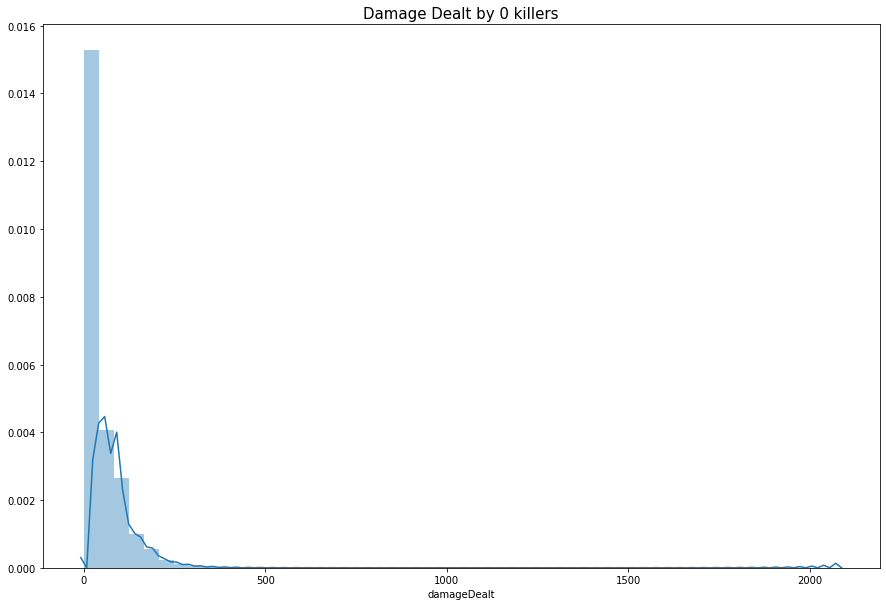

In [7]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,10))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

Well, most of them don't. Let's investigate the exceptions.

In [8]:
print("{} players ({:.4f}%) have won without a single kill!".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(train)))

data1 = train[train['damageDealt'] == 0].copy()
print("{} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(train)))

16666 players (0.3748%) have won without a single kill!
4770 players (0.1073%) have won without dealing damage!


Plot win placement percentage vs kills.

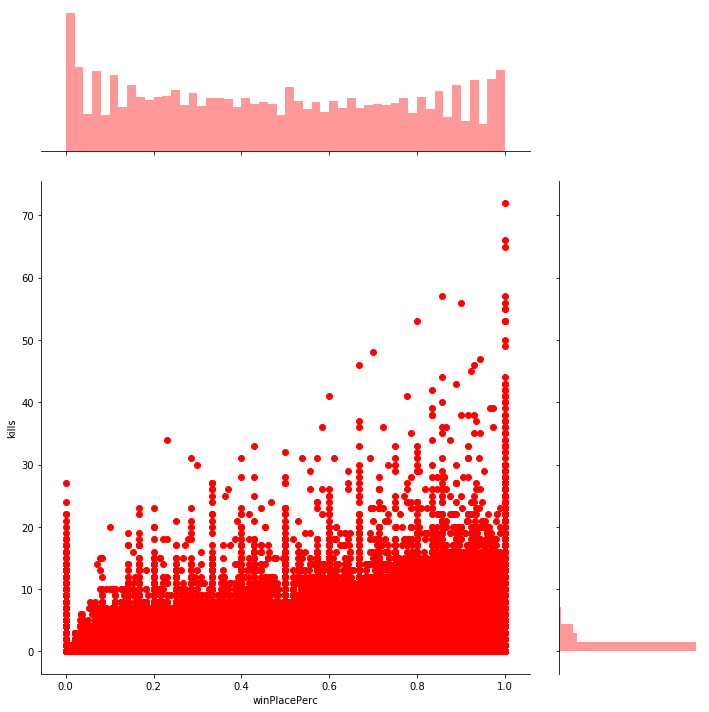

In [9]:
sns.jointplot(x="winPlacePerc", y="kills", data=train, height=10, ratio=3, color="r")
plt.show()

Apparentrly killing has a correlation with winning. Finally let's group players based on kills (0 kills, 1-2 kills, 3-5 kills, 6-10 kills and 10+ kills).

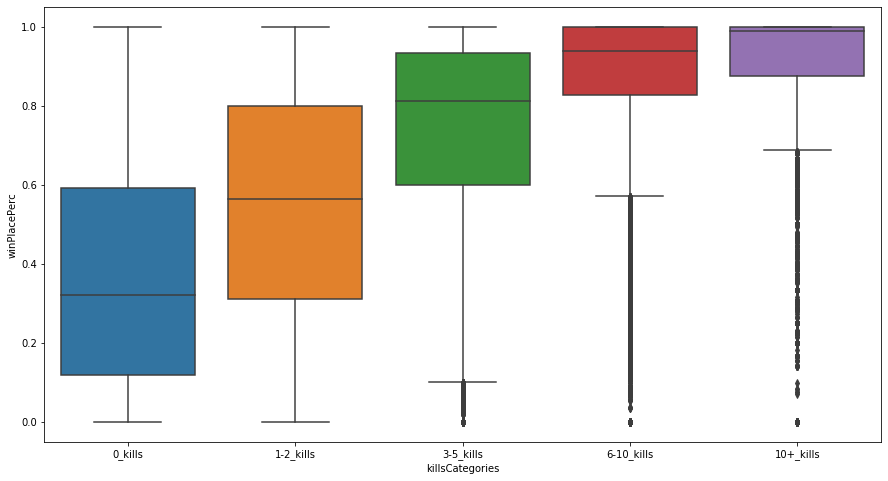

In [10]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

## The Runners

<img src="https://steemitimages.com/DQmRmYLRxu1vUhVtnFAA6bHFbShtr7Wdv1wLrPjdxbRZsjc/maxresdefault%20(2).jpg" alt="The Runners" style="width: 700px;"/>

In [11]:
print("The average person walks for {:.1f}m, 99% of people have walked {}m or less, while the marathoner champion walked for {}m.".format(train['walkDistance'].mean(), train['walkDistance'].quantile(0.99), train['walkDistance'].max()))

The average person walks for 1154.2m, 99% of people have walked 4396.0m or less, while the marathoner champion walked for 25780.0m.


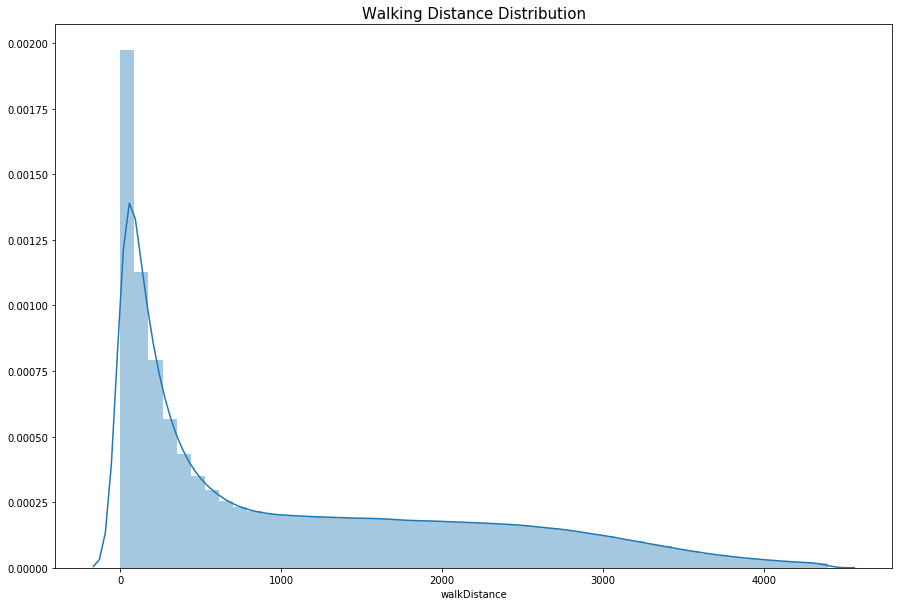

In [12]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

In [13]:
print("{} players ({:.4f}%) walked 0 meters. This means that they die before even taking a step or they are afk (more possible).".format(len(data[data['walkDistance'] == 0]), 100*len(data1[data1['walkDistance']==0])/len(train)))

99603 players (2.0329%) walked 0 meters. This means that they die before even taking a step or they are afk (more possible).


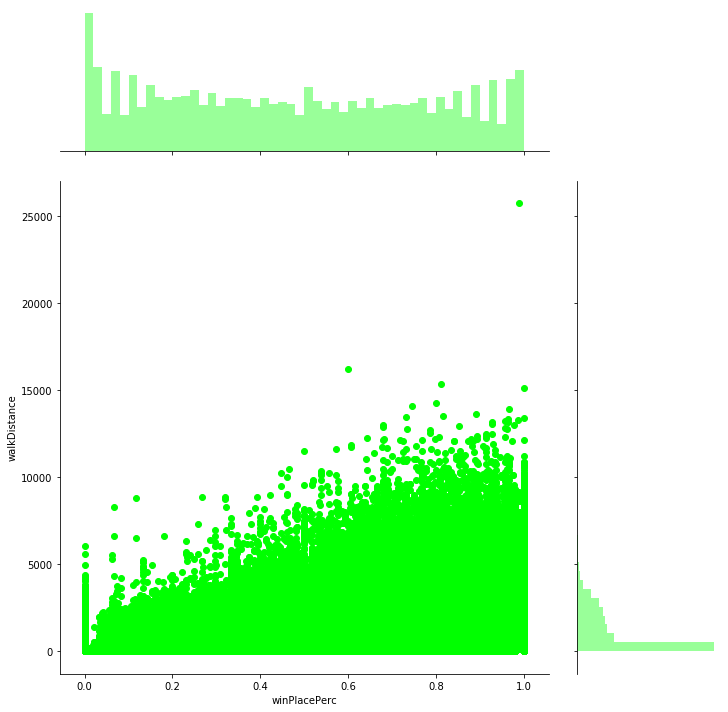

In [14]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train, height=10, ratio=3, color="lime")
plt.show()

Apparently walking has a high correlation with winPlacePerc.

## The Drivers

<img src="http://cdn.gamer-network.net/2018/metabomb/pubghowtodrivecarsandbikes.jpg" alt="The Drivers" style="width: 700px;"/>

In [15]:
print("The average person drives for {:.1f}m, 99% of people have drived {}m or less, while the formula 1 champion drived for {}m.".format(train['rideDistance'].mean(), train['rideDistance'].quantile(0.99), train['rideDistance'].max()))

The average person drives for 606.1m, 99% of people have drived 6966.0m or less, while the formula 1 champion drived for 40710.0m.


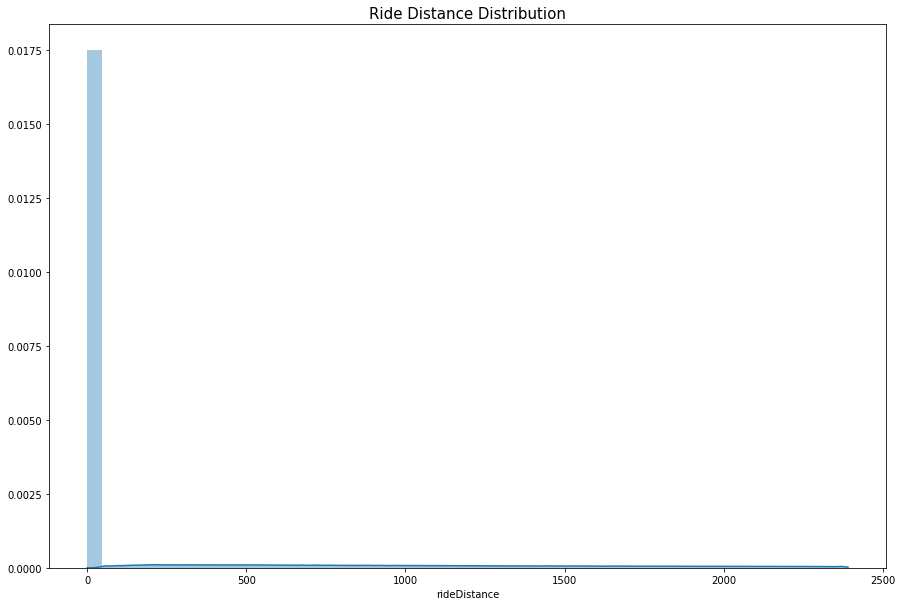

In [16]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.9)]
plt.figure(figsize=(15,10))
plt.title("Ride Distance Distribution",fontsize=15)
sns.distplot(data['rideDistance'])
plt.show()

In [17]:
print("{} players ({:.4f}%) drived for 0 meters. This means that they don't have a driving licence yet.".format(len(data[data['rideDistance'] == 0]), 100*len(data1[data1['rideDistance']==0])/len(train)))

3309429 players (23.1022%) drived for 0 meters. This means that they don't have a driving licence yet.


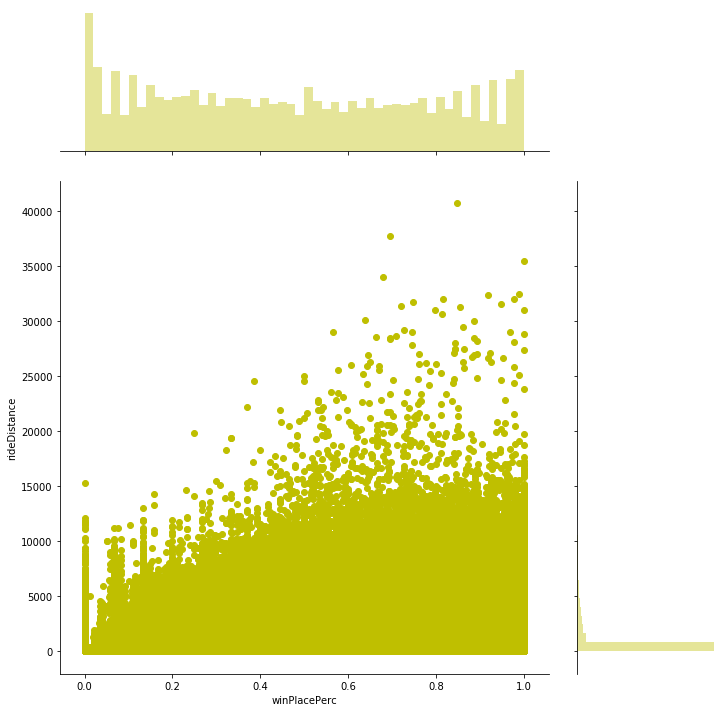

In [18]:
sns.jointplot(x="winPlacePerc", y="rideDistance", data=train, height=10, ratio=3, color="y")
plt.show()

There is a small correlation between rideDistance and winPlacePerc.

Destroying a vehicle in my experience shows that a player has skills. Let's check it.

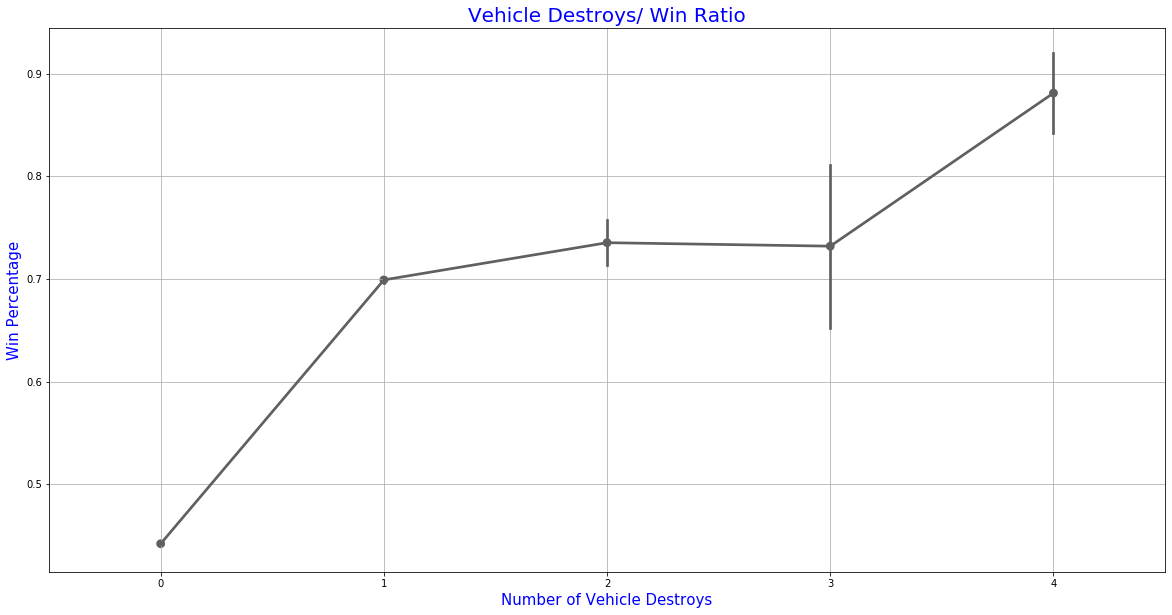

In [19]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=data,color='#606060',alpha=0.8)
plt.xlabel('Number of Vehicle Destroys',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Vehicle Destroys/ Win Ratio',fontsize = 20,color='blue')
plt.grid()
plt.show()

My experience was correct. Destroying a single vehicle increases your chances of winning!

## The Swimmers

<img src="https://i.ytimg.com/vi/tQxzsE0DijQ/maxresdefault.jpg" alt="The Swimmers" style="width: 700px;"/>

In [20]:
print("The average person swims for {:.1f}m, 99% of people have swimemd {}m or less, while the olympic champion swimmed for {}m.".format(train['swimDistance'].mean(), train['swimDistance'].quantile(0.99), train['swimDistance'].max()))

The average person swims for 4.5m, 99% of people have swimemd 123.0m or less, while the olympic champion swimmed for 3823.0m.


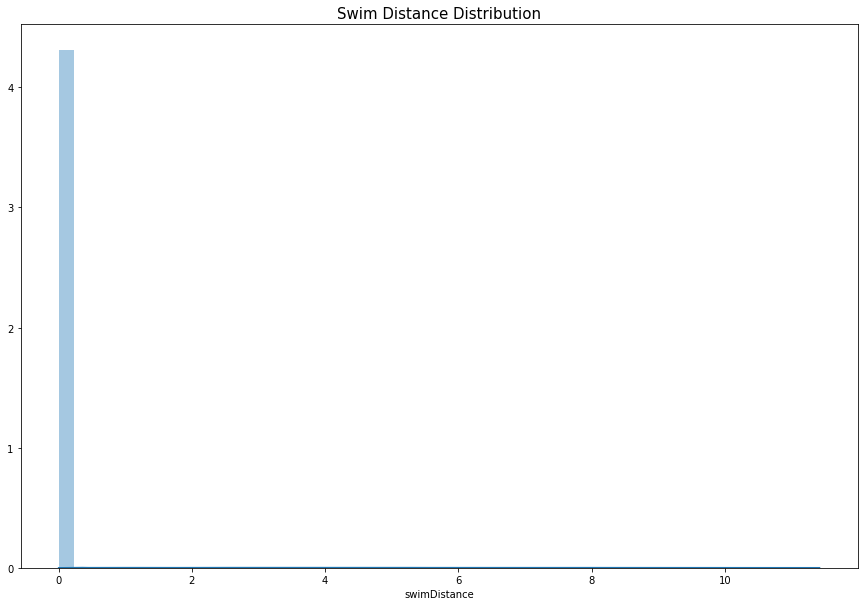

In [21]:
data = train.copy()
data = data[data['swimDistance'] < train['swimDistance'].quantile(0.95)]
plt.figure(figsize=(15,10))
plt.title("Swim Distance Distribution",fontsize=15)
sns.distplot(data['swimDistance'])
plt.show()

Almost no one swims. Let's group the swimming distances in 4 categories and plot vs winPlacePerc.

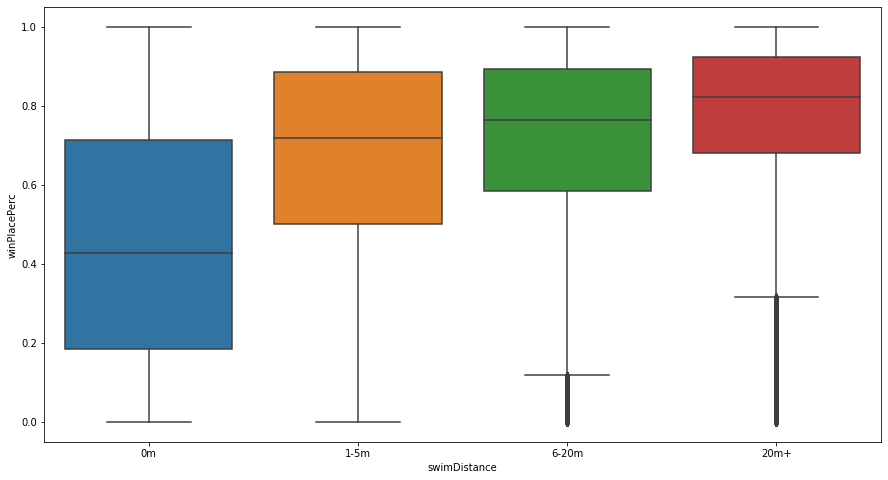

In [22]:
swim = train.copy()

swim['swimDistance'] = pd.cut(swim['swimDistance'], [-1, 0, 5, 20, 5286], labels=['0m','1-5m', '6-20m', '20m+'])

plt.figure(figsize=(15,8))
sns.boxplot(x="swimDistance", y="winPlacePerc", data=swim)
plt.show()

It seems that if you swim, you rise to the top. In PUBG there are currently 3 maps. One of them has almost no water. Keep that in mind. I might plan on doing analysis to find out in which map a match is played.

## The Healers

<img src="https://i.ytimg.com/vi/xfI9XljX51k/maxresdefault.jpg" alt="The Healers" style="width: 700px;"/>

In [23]:
print("The average person uses {:.1f} heal items, 99% of people use {} or less, while the doctor used {}.".format(train['heals'].mean(), train['heals'].quantile(0.99), train['heals'].max()))
print("The average person uses {:.1f} boost items, 99% of people use {} or less, while the doctor used {}.".format(train['boosts'].mean(), train['boosts'].quantile(0.99), train['boosts'].max()))

The average person uses 1.4 heal items, 99% of people use 12.0 or less, while the doctor used 80.
The average person uses 1.1 boost items, 99% of people use 7.0 or less, while the doctor used 33.


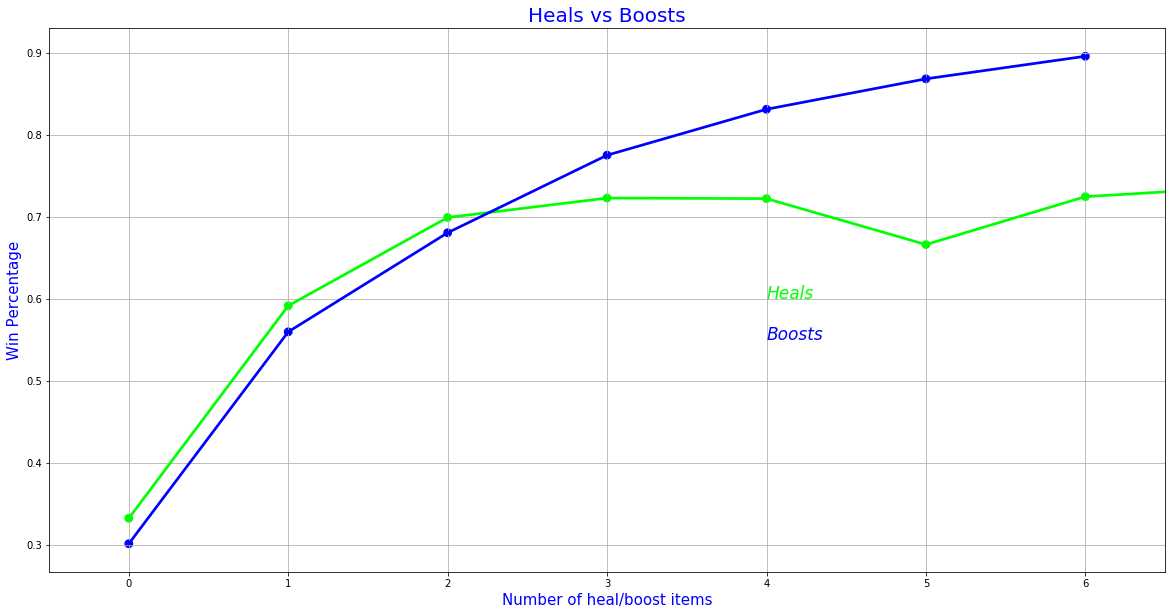

In [24]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 17,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

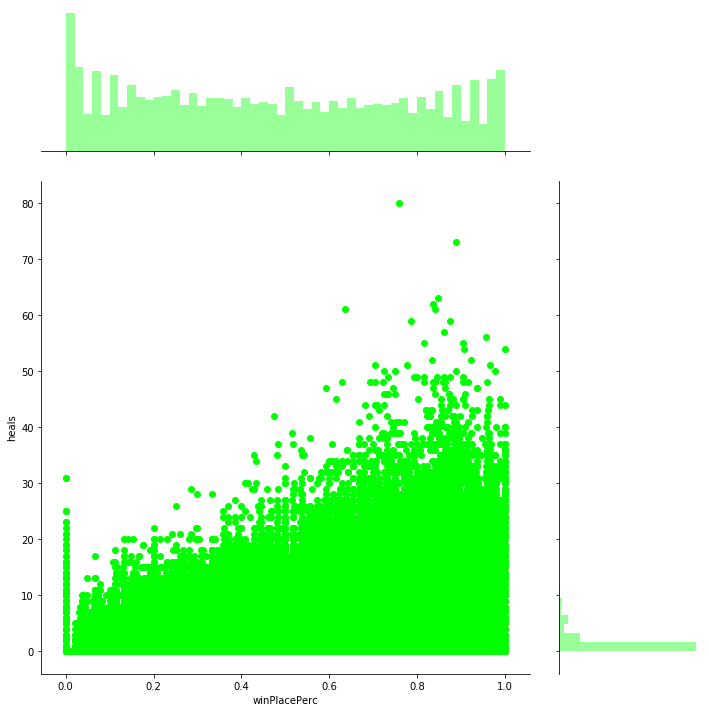

In [25]:
sns.jointplot(x="winPlacePerc", y="heals", data=train, height=10, ratio=3, color="lime")
plt.show()

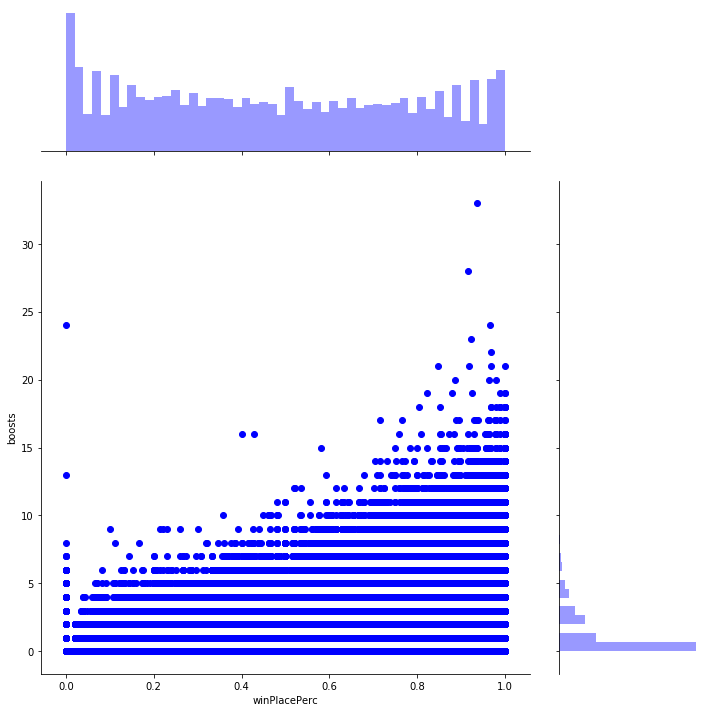

In [26]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, height=10, ratio=3, color="blue")
plt.show()

So healing and boosting, definitely are correlated with winPlacePerc. Boosting is more.

In every plot, there is an abnormal behavior when values are 0.

## Solos, Duos and Squads

There are 3 game modes in the game. One can play solo, or with a friend (duo), or with 3 other friends (squad). 100 players join the same server, so in the case of duos the max teams are 50 and in the case of squads the max teams are 25. 

In [ ]:
solos = train[train['numGroups']>50]
duos = train[(train['numGroups']>25) & (train['numGroups']<=50)]
squads = train[train['numGroups']<=25]
print("There are {} ({:.2f}%) solo games, {} ({:.2f}%) duo games and {} ({:.2f}%) squad games.".format(len(solos), 100*len(solos)/len(train), len(duos), 100*len(duos)/len(train), len(squads), 100*len(squads)/len(train)))

In [ ]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='black',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
plt.text(37,0.6,'Solos',color='black',fontsize = 17,style = 'italic')
plt.text(37,0.55,'Duos',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(37,0.5,'Squads',color='#3399FF',fontsize = 17,style = 'italic')
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

Hmm, very interesting. Solos and duos behave the same, but when playing squads kills don't matter that much.

The attribute DBNOs means enemy players knocked. A "knock" can happen only in duos or squads, because the teammates have the chance to "revive" the knocked player in a given time. So a knocked player can be revived or die. If he is revived, the next time he will be knocked, his teammates will have less time to revive him.

The attribute assist can also happen only in duos or squads. It generally means that the player had an involvement in a kill.

The attribute revive also happens in duos or squads.

In [ ]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='DBNOs',y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8)
sns.pointplot(x='DBNOs',y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=duos,color='#FF6666',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=squads,color='#CCE5FF',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=duos,color='#660000',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=squads,color='#000066',alpha=0.8)
plt.text(14,0.5,'Duos - Assists',color='#FF6666',fontsize = 17,style = 'italic')
plt.text(14,0.45,'Duos - DBNOs',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(14,0.4,'Duos - Revives',color='#660000',fontsize = 17,style = 'italic')
plt.text(14,0.35,'Squads - Assists',color='#CCE5FF',fontsize = 17,style = 'italic')
plt.text(14,0.3,'Squads - DBNOs',color='#3399FF',fontsize = 17,style = 'italic')
plt.text(14,0.25,'Squads - Revives',color='#000066',fontsize = 17,style = 'italic')
plt.xlabel('Number of DBNOs/Assits/Revives',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Duo vs Squad DBNOs, Assists, and Revives',fontsize = 20,color='blue')
plt.grid()
plt.show()

## Pearson correlation between variables

In [ ]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In terms of the target variable (winPlacePerc), there are a few variables high medium to high correlation. The highest positive correlation is walkDistance and the highest negative the killPlace.

**Let's zoom to the top-5 most positive correlated variables with the target.**

In [ ]:
k = 5 #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Let's plot the above variables and the killPlace variable as pairs.

In [ ]:
sns.set()
cols = ['winPlacePerc', 'walkDistance', 'boosts', 'weaponsAcquired', 'damageDealt', 'killPlace']
sns.pairplot(train[cols], size = 2.5)
plt.show()

## Feature Engineering

A game in PUBG can have up to 100 players fighting each other. But most of the times a game isn't "full". There is no variable that gives us the number of players joined. So lets create one.

In [ ]:
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')

In [ ]:
data = train.copy()
data = data[data['playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

Based on the "playersJoined" feature we can create (or change) a lot of others to normalize their values. For example i will create the "killsNorm" and "damageDealtNorm" features. When there are 100 players in the game it might be easier to find and kill someone, than when there are 90 players. So i will normalize the kills in a way that a kill in 100 players will score 1 (as it is) and in 90 players it will score (100-90)/100 + 1 = 1.1. This is just an assumption. You can use different scales.

In [ ]:
train['killsNorm'] = train['kills']*((100-train['playersJoined'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
train[['playersJoined', 'kills', 'killsNorm', 'damageDealt', 'damageDealtNorm']][5:8]

Another simple feature is the sum of heals and boosts. Also the sum of total distance travelled.

In [ ]:
train['healsAndBoosts'] = train['heals']+train['boosts']
train['totalDistance'] = train['walkDistance']+train['rideDistance']+train['swimDistance']

When using boosting items you run faster. They also help staying out of the zone (PUBG term) and loot more (meaning walking more). So lets create a feature boosts per walking distance. Heals don't make you run faster, but they also help staying out of the zone and loot more. So lets create the same feature for heals also.

In [ ]:
train['boostsPerWalkDistance'] = train['boosts']/(train['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where boosts>0 and walkDistance=0. Strange.
train['boostsPerWalkDistance'].fillna(0, inplace=True)
train['healsPerWalkDistance'] = train['heals']/(train['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where heals>0 and walkDistance=0. Strange.
train['healsPerWalkDistance'].fillna(0, inplace=True)
train['healsAndBoostsPerWalkDistance'] = train['healsAndBoosts']/(train['walkDistance']+1) #The +1 is to avoid infinity.
train['healsAndBoostsPerWalkDistance'].fillna(0, inplace=True)
train[['walkDistance', 'boosts', 'boostsPerWalkDistance' ,'heals',  'healsPerWalkDistance', 'healsAndBoosts', 'healsAndBoostsPerWalkDistance']][40:45]

Same, let's create the feature "killsPerWalkDistance".

In [ ]:
train['killsPerWalkDistance'] = train['kills']/(train['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where kills>0 and walkDistance=0. Strange.
train['killsPerWalkDistance'].fillna(0, inplace=True)
train[['kills', 'walkDistance', 'rideDistance', 'killsPerWalkDistance', 'winPlacePerc']].sort_values(by='killsPerWalkDistance').tail(10)

0 walking distance and many kills? Also most have winPlacePerc=1. Definitelly cheaters.

Earlier in the kernel we did EDA for Solos, Duos and Squads. Lets create a column for them.

In [ ]:
train['team'] = [1 if i>50 else 2 if (i>25 & i<=50) else 4 for i in train['numGroups']]

In [ ]:
train.head()

So we created 10 features. I hope some of them to be useful.

### Thank you if you reached this point! This is my first kernel ever. An upvote would be really appreciated and help me keep going!

### In progress.. 